# Netflix recommendation engine
Data source:
https://www.kaggle.com/shivamb/netflix-shows

Supplementary info, check out in Tableau: https://public.tableau.com/views/Netflix_16175273771650/Dashboard1?:language=en-GB&:display_count=y&publish=yes&:origin=viz_share_link

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
movie = pd.read_csv("../input/netflix-shows/netflix_titles.csv")

In [ ]:
print(movie.shape)
movie.head(10)

In [ ]:
movie.isnull().sum()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Palette
colour = ['#221f1f', '#b20710', '#e50914','#f5f5f1']
sns.palplot(colour)
ax = plt.gca()

plt.title("Netflix brand palette")
for i, name in enumerate(colour):
    ax.text(i-0.45,1, name) 
plt.show()

In [ ]:
movie_type = movie.groupby('type').show_id.count()
plt.bar(x = movie_type.index, height=movie_type.values, color=colour)

In [ ]:
plt.figure(figsize=(12,15))
sns.countplot(y="release_year", data=movie, palette=colour, order=movie['release_year'].value_counts().index)
plt.text(-2,-2,"Which year has the most movies/TV shows be released?", family='sans-serif', fontsize=15, weight='bold')

In [ ]:
movie['date_added'] = pd.to_datetime(movie['date_added'])
movie['date_added_year'] = movie['date_added'].dt.year
movie['date_added_month'] = movie['date_added'].dt.month

In [ ]:
sns.heatmap(movie.loc[movie['date_added_year'].fillna(0).astype(int).between(2010,2020)].
            pivot_table(values='show_id',index='date_added_year',columns='date_added_month',aggfunc='count'),
           cmap='Reds')
plt.text(-2,-2,"Which month has the most movies/TV shows be added?", family='sans-serif', fontsize=15, weight='bold')

In [ ]:
pip install plotly==4.14.3

In [ ]:
import plotly.graph_objects as go

In [ ]:
import plotly.express as px

In [ ]:
country = movie.groupby('country').show_id.count().reset_index()
country = country.rename(columns={'show_id':'no of movies'})
fig = px.treemap(country, path=['country','no of movies'], values='no of movies',
                title='Distribution by country')
fig.show()

In [ ]:
import itertools as it

In [ ]:
pip install wordcloud

In [ ]:
import nltk
from wordcloud import WordCloud

In [ ]:
genre = movie['listed_in'].tolist()

In [ ]:
cloud = WordCloud(background_color = 'white',colormap='Reds',max_words = 120).generate(''.join(list(it.chain(*genre))))

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(cloud)
plt.axis('off')
plt.text(-1,-10,"Most frequent keywords in attribute", family='sans-serif', fontsize=20, weight='bold')

In [ ]:
from PIL import Image

In [ ]:
mask = np.array(Image.open('../input/netflix-icon/453-4532423_icon-netflix-logo-png-transparent-png.png'))
cloud2 = WordCloud(background_color='white',colormap='Reds',max_words=150, mask=mask).generate(''.join(movie['title'].tolist()))

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(cloud2)
plt.axis('off')
plt.text(-1,-10,"Most common words used in movies/TV shows' titles", family='sans-serif', fontsize=20, weight='bold')

# Bag-of-Words Model
When analyzing large amounts of natural language data(NLP), text must be converted into numbers, in form of vectors/matrix, as machine cannot work with raw text directly.

A popular and simple method is called the bag-of-words model.

Why it is named as “bag” of words is because all words in the document are disordered. The model only counts the occurance, and the positions are not considered.

A problem with bag-of-words model is that words with high frequency will dominate and get larger score), but higher frequency doesn't mean that word is informative, eg is/are/an/the.

Term Frequency – Inverse Document Frequency(TF-IDF) is introduced to "penalize" those highly frequent words. Term frequency and inverse document frequency refer to the frequency of the word and how rare the word is across documents respectively by giving a score, help highlighting distinct words to distinguish the difference. 

# Tfidftransformer vs. Tfidfvectorizer

Both can convert the text of raw documents into a matrix of TF-IDF.

Tfidftransformer: First compute word counts by CountVectorizer, then Tfidftransformer compute IDF values and Tf-idf scores.
Tfidfvectorizer: compute at once

Use Tfidftransformer if word count vectors are needed for different tasks.

In [ ]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#Replace NaN with an empty string, since the converter cannot deal with integer/float
movie['description'] = movie['description'].fillna('')

# Tfidftransformer

In [ ]:
#removing stopwords
tfidf = TfidfVectorizer(stop_words='english')

#get the tf-idf scores
#create TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(movie['description'])

#shape of tfidf_matrix
tfidf_matrix.shape

In [ ]:
pd.DataFrame(tfidf_matrix[0].T.todense(), index=tfidf.get_feature_names(), columns=["tf-idf score"])

# Tfidfvectorizer

In [ ]:
#CountVectorizer: Convert a collection of text documents to a matrix of token counts
#TfidfTransformer: Transform a count matrix to a normalized tf or tf-idf representation

from sklearn.pipeline import Pipeline

pipe = Pipeline([('cv', CountVectorizer(stop_words='english')),
                ('tfid', TfidfTransformer())]).fit(movie['description'])

print("CountVectorizer_matrix: {}".format(pipe['cv'].transform(movie['description']).toarray()))
print("CountVectorizer_matrix: {}".format(pipe['tfid'].idf_))

In [ ]:
pipe['tfid'].idf_.shape

In [ ]:
#The lower the IDF value of a word, the less unique it is to any particular document
pd.DataFrame(pipe['tfid'].idf_, index=pipe['cv'].get_feature_names(), columns=['idf_weights'])

# Limitation of TF-IDF
As the ordering of the sentence is discarded.
- compute similarity directly in the word-count space, which may be slow for large vocabularies
- assume the counts of different words are independent
- synonyms between words are ignored, eg trip and journey

# Content-based filtering VS collaborative filtering
- Content-based filtering:
    - recommend other similar items by item features 
    - does not require other users' data during recommendations to one user.
- Collaborative filtering:
    - mimics user-to-user recommendations
    - does not need the item features

# Cosine similarity

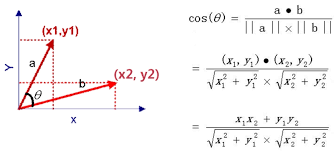

Three way to calculate similiarity
- Euclidean distance
- Pearson correlation
- Cosine similiarity

Here cosine similarity is used. It measures the cosine of the angle between two vectors projected in a multi-dimensional space to find out how similar the documents are irrespective of their size. The smaller the angle, higher the cosine similarity.

It is advantageous because even if the two similar documents are far apart by the Euclidean distance (due to the size of the document).

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix)

In [ ]:
cosine_sim

scikit-learn also provides pairwise metrics (aka kernels in machine learning parlance) that work for both dense and sparse representations of vector collections. In calculating similarity, a dot product is also needed (aka linear kernel).

On L2-normalized data, linear_kernel is equivalent to cosine similarity.

# Calculate cosine similarity by sklearn.pairwise.package

In [ ]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim1 = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
cosine_sim1

# Recommendation engine by description

In [ ]:
programme_list=movie['title'].to_list()

In [ ]:
def recommend(title, cosine_similarity=cosine_sim):
    index = programme_list.index(title)
    sim_score = list(enumerate(cosine_sim[index]))
    sim_score = sorted(sim_score, key= lambda x: x[1], reverse=True)[1:11] #position 0 is the movie itself, thus exclude
    recommend_index = [i[0] for i in sim_score]
    rec_movie = movie['title'].iloc[recommend_index]
    rec_score = [round(i[1],4) for i in sim_score]
    rec_table = pd.DataFrame(list(zip(rec_movie,rec_score)), columns=['Recommend programme','Similarity(0-1)'])
    return rec_table

In [ ]:
recommend('Avengers: Infinity War')

The first recommended programme of "Why Are We Getting So Fat?" is "Forks Over Knives", which is also health-related and emphasing the importance of what we had eaten.

In [ ]:
recommend('Why Are We Getting So Fat?')

"About Time" is a British romantic comedy-drama film about a man with the ability of time travel.

From the recommendation list, some romantic programmes are suggested, while programmes with description containing abverbs of time are also listed, eg "Tomorrow with You", "Running Out Of Time", "Second 20s" that "Running Out Of Time" is a Hong Kong action thriller film, rather than romantic firm.

In [ ]:
recommend('About Time')

"Ninja Hattori" is actually the english name of "忍者ハットリくん", so the similarity score is far more than others, and on the top of recommedation list, ie recommend itself again.

This fault is attributed by the sources of dataset, instead of the algorithm. We need to beware of the dataset whether there are duplicates that showcased in different language in our training set.

In [ ]:
recommend('忍者ハットリくん')

# Problem of movie series

As above recommendation engine is constructed based on description only, it probably wouldn't suggest the movies in series, but movies with more similar key words.

Let's take "Indiana Jones" series as example, its serial movie aren't the top recommendation.

In [ ]:
recommend("Indiana Jones and the Last Crusade")

Sometimes, we watch movies not only based on genres, but the directors' filming style.

Steven Spielberg is a famous director and he has 12 movies in this dataset, including Indiana Jones' series, so movies filmed by him should also on the list.

In [ ]:
movie.loc[movie['director']=='Steven Spielberg']

# Recommendation engine by 5 attributes

In [ ]:
#select programme type,country,genres,director & description
#join all the info together
#convert all words into lowercase so that algorithm will not distinguish as independent words
def bag_of_words(df):
    features = df['type']+' '+df['country']+' '+df['listed_in']+' '+df['director']+' '+df['description']
    return features.fillna('').str.lower()

In [ ]:
features = bag_of_words(movie)

In [ ]:
features.head(10)

In [ ]:
tfidf_matrix2 = tfidf.fit_transform(features)                
tfidf_matrix2.shape

In [ ]:
cosine_sim2 = cosine_similarity(tfidf_matrix2)

In [ ]:
def recommend2(title, cosine_similarity=cosine_sim2):
    index = programme_list.index(title)
    sim_score = list(enumerate(cosine_sim2[index]))
    sim_score = sorted(sim_score, key= lambda x: x[1], reverse=True)[1:11] #position 0 is the movie itself, thus exclude
    recommend_index = [i[0] for i in sim_score]
    rec_movie = movie['title'].iloc[recommend_index]
    rec_score = [round(i[1],4) for i in sim_score]
    rec_table = pd.DataFrame(list(zip(rec_movie,rec_score)), columns=['Recommend programme','Similarity(0-1)'])
    return rec_table

Take Indiana Jones's series as example again, new recommendation engine now suggest its serial movies in the highest ranking. 

Also, Steven Spielberg's movies, such as "Schindler's List", "Lincoln", "The Adventures of Tintin Hook" are also on the list. "Indiana Jones and the Last Crusade" is about searching Holy Grail, in which story plot is similar to "Monty Python and the Holy Grail", so has a higher ranking.

In [ ]:
recommend2("Indiana Jones and the Last Crusade")